# Exploration of the Fitbit Data

In [1]:
import acquire
import prepare
import explore

import seaborn as sns
import matplotlib.pyplot as plt

# data manipulation 
import numpy as np
import pandas as pd

from datetime import datetime
import itertools

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline

from sklearn.model_selection import TimeSeriesSplit

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
fitbit = prepare.wrangle_fitbit_data()

In [3]:
fitbit.head()

,calories,Calories Burned,Steps,Distance,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories
2018-04-26,2000.0,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0
2018-04-27,2000.0,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0
2018-04-28,2000.0,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0
2018-04-29,2000.0,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0
2018-04-30,2000.0,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0


In [4]:
# We make sure that there are no null values
fitbit.isnull().sum()

calories                  0
Calories Burned           0
Steps                     0
Distance                  0
Floors                    0
Minutes Sedentary         0
Minutes Lightly Active    0
Minutes Fairly Active     0
Minutes Very Active       0
Activity Calories         0
dtype: int64

In [5]:
# We look at the range of the data, to make sure that there are not gaps
explore.find_range(fitbit)

Date Range: 2018-04-26 00:00:00 to 2018-12-28 00:00:00


In [6]:
fitbit.index.max() - fitbit.index.min()

Timedelta('246 days 00:00:00')

In [7]:
fitbit.resample("D").mean().count()

calories                  247
Calories Burned           247
Steps                     247
Distance                  247
Floors                    247
Minutes Sedentary         247
Minutes Lightly Active    247
Minutes Fairly Active     247
Minutes Very Active       247
Activity Calories         247
dtype: int64

As we can see - there are no gaps in the data, as the number of rows match the number of days in the data.

## Split

In [8]:
train = fitbit[:"2018-10"]
validate = fitbit["2018-11"]
test = fitbit["2018-12"]

In [9]:
train.index.max(), validate.index.max(), test.index.min()

(Timestamp('2018-10-31 00:00:00'),
 Timestamp('2018-11-30 00:00:00'),
 Timestamp('2018-12-01 00:00:00'))

## Explore

We need to predict all the values - according to the spec. But, in order to effective create the models. we need to first understand some important features, like the subjects habits, if there is any seasonality, and if there are any trends or outliers.

In [10]:
train.shape[1]

10

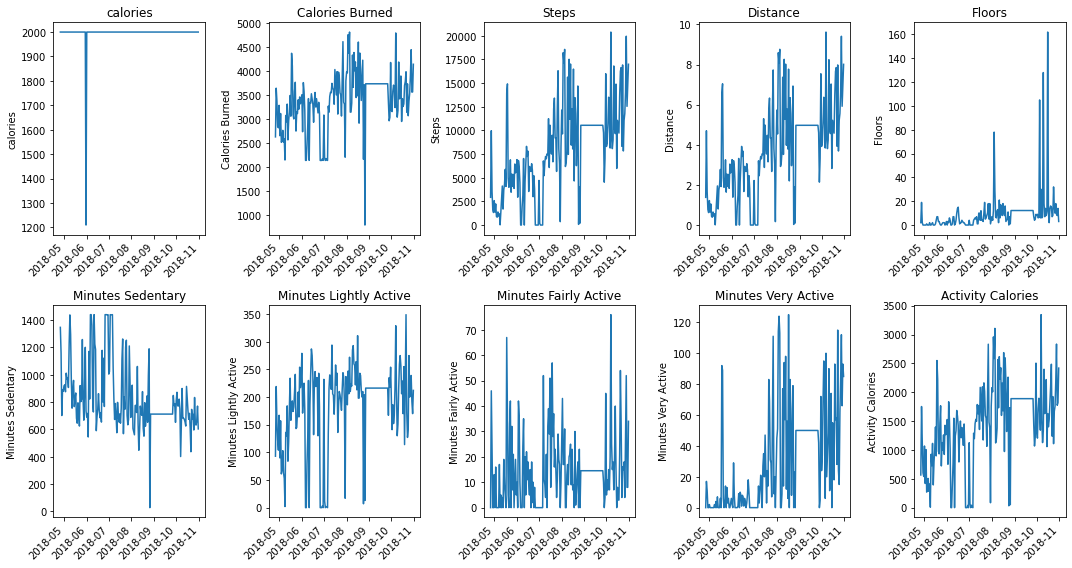

In [11]:
# Is there any seasonality in the data? 

f = plt.figure(figsize=(15,8))
# plt.suptitle("Is there any seasonality in the data?")
for count, col in enumerate(train):
    f.add_subplot(2,5, count+1)
    sns.lineplot(data=train, y=col, x=train.index)
    plt.title(train.columns[count])
    plt.xticks(rotation= 45, ha="right")
plt.tight_layout()
plt.show()

Just by looking at the different categories, there doesn't seem to be any major seasonality that can be seen on a monthly basis. Given that we are not exacly sure what type of activities the subject was being asked to do, it is not surprising. 

In terms of trends, there does seem to be a general increase in activity, and a decrease in "sedimentary" activity. 

Unfortunately, there is very little information about caloric intake, which will make it significantly difficult to predict weight.

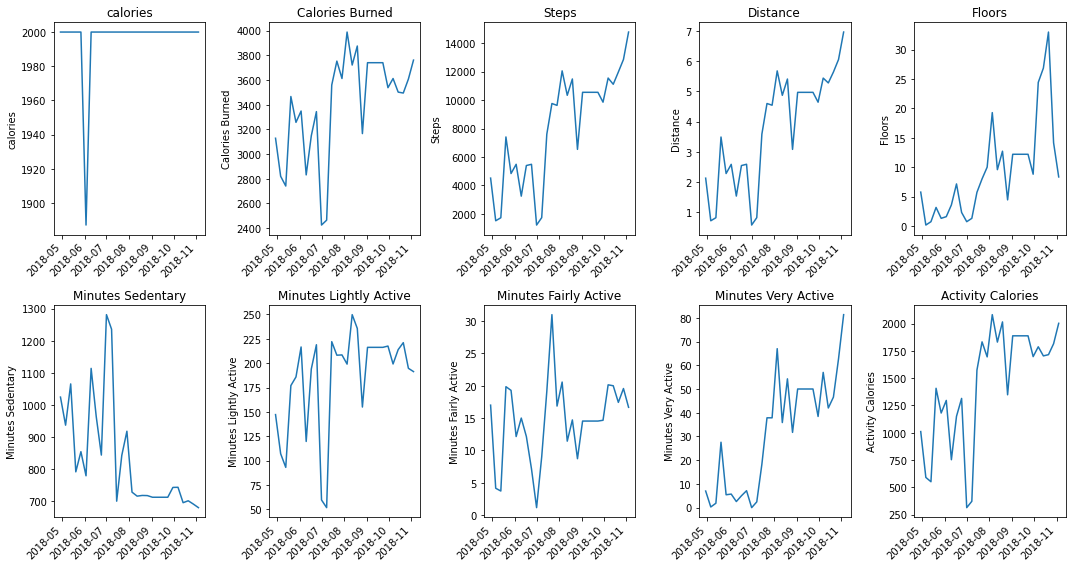

In [12]:
# Are there any patterns looking at the data over a weekly period?

train_w = train.resample("W").mean()

f = plt.figure(figsize=(15,8))
# plt.suptitle("Is there any seasonality in the data?")
for count, col in enumerate(train_w):
    f.add_subplot(2,5, count+1)
    sns.lineplot(data=train_w, y=col, x=train_w.index)
    plt.title(train_w.columns[count])
    plt.xticks(rotation= 45, ha="right")
plt.tight_layout()
plt.show()

Here, the trends mentioned earlier are even more clear.

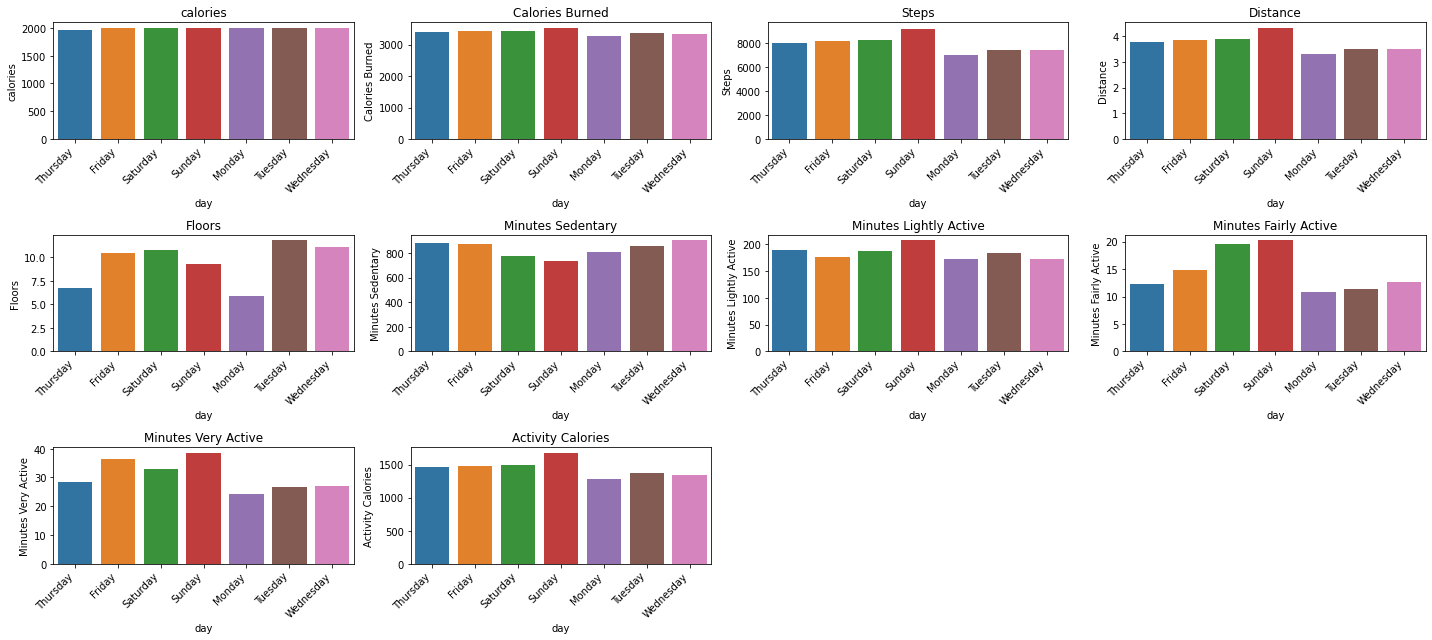

In [13]:
# Where there any particular days of the week that the subject was more, or less, active?

train["day"] = train.index.day_name()

f = plt.figure(figsize=(20,9))
for count, col in enumerate(train):
    if col != "day":
        f.add_subplot(3,4, count+1)
        sns.barplot(data=train, x="day", y=col, ci=False)
        plt.title(col)
        plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

From the data, I suspect that the subject would likely start being more active during the second half of the week, starting from Thursday, through Sunday, and then being less active Monday - Wednesday. Overall, it seemed that the weekend was when the subject was most active, with Sunday being the subject's most active day, regardless of the intensitve of activity. 

That being said, however, it dpes seem that there were not hugely significant differences on when the subject would workout.

One interesting thing to note is the floors. It is interesting because the subject seems to climb a lot of floors both on week days, and weekend, which would suggest the subject either lives in a house with several stories, or hte subject might perhaps not be entirely relaint of a car for transportation, meaning that it has to walk. At the same time, it is difficult to measure the effectiveness of the fitbit's ability to count floors, so this could largely be a miscalculation.

In [14]:
def seasonal_decomposition(df, col):
    y = df[col].resample("D").mean()

    result = sm.tsa.seasonal_decompose(y)
    decomposition = pd.DataFrame({
            "y": result.observed,
        "trend": result.trend,
        "seasonal": result.seasonal,
        "resid": result.resid,
    })

    decomposition.iloc[:,1:].plot()

Text(0.5, 1.0, 'Is the trend seen in inactivity?')

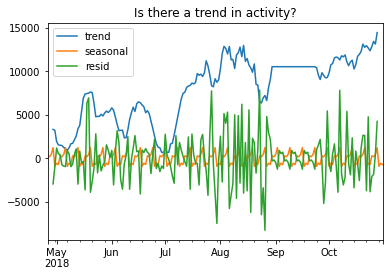

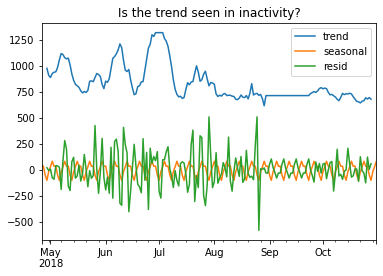

In [15]:
# Lets confirm seasonality on a weekly basis

seasonal_decomposition(train, "Steps")
plt.title("Is there a trend in activity?")
seasonal_decomposition(train, "Minutes Sedentary")
plt.title("Is the trend seen in inactivity?")

We can definitively see that there is a positve trend when it comes to activity over time. Weidly, however, the trend doesn't seem to be reflected when we look at the inactivity (as you would expect to see a decrease).

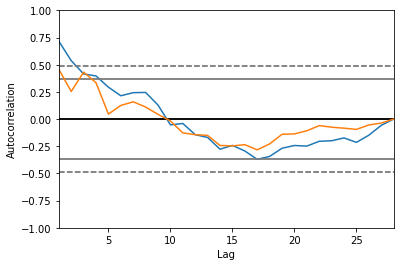

In [16]:
# Can we confirm some seasonality with a lagplot?

pd.plotting.autocorrelation_plot(train.Steps.resample("W").mean())

pd.plotting.autocorrelation_plot(train["Minutes Sedentary"].resample("W").mean())

There doesn't seem to be any notable seasonality, as there are no clear peaks, and the majority of the data seems to fall under the confidence belts, which indicates that it is mostly noise, without significant correlations.

The next thing I would like to look at is whether we can use steps and distance to predict the subjects height, and potentially sex.

In [17]:
# What is the subjects average number of steps to complete a mile?
mile_1 = train[train.Distance.between(1, 1.05)].Steps[0]
mile_2 = train[train.Distance.between(2, 2.1)].Steps[0]

In [18]:
# what is the patients stride length?
stride = (5280/(mile_2/2))*12

print(f'The subjects legnth stride, in inches, is {stride:2.2f}')

The subjects legnth stride, in inches, is 29.38


In [19]:
# Knowing the subjects length stride, we can now calculate the height. 
# using the information found here: https://lowellrunning.com/stepspermile/, we divide the stride by a constant number,
# and we get the height, in inches.

print(f'The subject\'s height, in inches, is {stride / .413:.2f}. This is 5.10 feet.')

The subject's height, in inches, is 71.14. This is 5.10 feet.


Given that the average height for men in 5.6 ft, and the average height for women is 5.2 ft, I would suspect that the subject is male. 

In [20]:
# Can we calculate caloric intake? 
# By looking at the number of calories consumed, and the number of calories burned, can we calculate if the
# subject has lost or gain weight since the begining of the experiment?

train["calory_deficit"] = train.calories - train["Calories Burned"]

Text(0.5, 1.0, 'Net Calories Consumed')

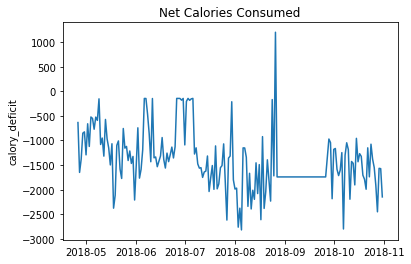

In [21]:
sns.lineplot(data=train, x=train.index, y="calory_deficit")
plt.title("Net Calories Consumed")

In [22]:
# Mean caloric deficit

round(train.calory_deficit.mean(),2)

-1398.47

Interestingly, the subject did seems to decrease its overall net caloric intake over time. This means that the subjects increase in exercise did likely lead to the subject loosing some weight. It is difficult to predict how accurate this is, however, given that we have very little actual data to indicate caloric intake. 

That being said, if the subject did actually have a caloric deficit of about 550, that means that the subject was likely loosing weight. 

In [23]:
train[train.calory_deficit > 0].shape

(1, 12)

In [24]:
train[train.calory_deficit <= train.calory_deficit.mean()].shape

(104, 12)

In [25]:
print(f'The subject had an above average calory deficit for {188 / 7:.0f} weeks')

The subject had an above average calory deficit for 27 weeks


There were 27 weeks in which the subject had a caloric deficit of over 1000 calories or higher. This can help us approximate how many pounds the subject might have lost. After doing some reaserch, we found that with a caloric deficit of 500, over 7 days, we can expect a person to lose about 1 pount. This means that, over 27 weeks, our subject could have lost up to 40 pounds. That being said, it is difficult to believe that this is remotely accurate, as there is only one day where the subject ate more calories than he/she burned. 

It is also difficult to calculate the subjects weight loss / gain, because we also don't have a metabolic rate, which could help us calculate how many calories, on average, the subject would need to ingest daily to loose weight.



This is what we have discovered so far:

1. Subject is likely male, and is about 5.10 ft high
1. The subject seems to be more active on Sunday than any other day. 
1. Subject has a strong positive trend for activity over the year, meaning that we see that the subject was becoming more active with time.
1. There is no discernable pattern in terms of activity over a weekly period.
1. Given the subjects height, and gender, we can use information on the internet to get an approximation of its weight, which would be around: 149 - 183 lbs. Ideally, we would look at the subjects caloric intake and activities to predict 
1. The mean caloric deficit for the subject was about 1,300 calories. Despite now being able to accurately predict the overall weight change of the subject, I suspect the subject likely lost some weight during the time of the experiment. 

# Modeling

Now that we have a better understanding of the subjects behavior, we can begin to look at modeling. Given the specs, we need to predict the next two weeks, starting from December 28th, 2018.

Some things that we do need to keep in mind, it will be difficult to predict the subject's immediate bahavior, is this is close to the holidays, where most people change their behavior. 

In [26]:
fitbit = prepare.wrangle_fitbit_data()

train = fitbit[:"2018-10"]
validate = fitbit["2018-11"]
test = fitbit["2018-12"]

In [27]:
import model

In [28]:
target_variable = "calories"

In [29]:
# establish a baseline
predictions_calories = model.create_predictions_df(train, validate, "calories")

In [30]:
# simple_average

y_pred = model.run_simple_average(train, target_variable)
predictions_calories["simple_average"] = y_pred

In [32]:
# moving average

rolling_period = [1, 7, 14]

y_pred = model.run_moving_average(train, target_variable, 7)
predictions_calories["moving_average"] = y_pred

In [38]:
train.index.max()

Timestamp('2018-10-31 00:00:00')

In [46]:
# holts prediction

holt, y_pred = model.run_holts(train, validate, target_variable)
predictions_calories["holts_prediction"] = y_pred

Text(0.5, 1.0, 'RMSE Score')

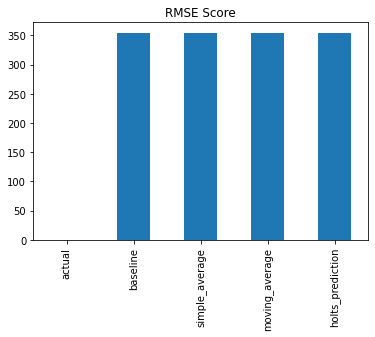

In [48]:
model.plot_rmse(predictions_calories)
plt.title("RMSE Score")